## Goals to complete:
- Build raw neural network
- Use Keras Resnet50

## Steps:
1. **Write python file to seperate images**
    * Class 1
        * 0.jpg
        * 1.jpg
        * ...
    * Class 2
        * 0.jpg
        * 1.jpg
        * ...
    * ...
    * Class n
2. **Visualize data**
3. **Create image generator**
4. **Load data**
5. **Create model**
6. **Fit model**
7. **Plot history**
8. **Check overfitting**
9. **Get result**

## Notes:
- (Accuracy -- Val_accuracy) and (Loss -- Val_loss): Check overfitting
- MaxPooling2D: Reduce image size

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

### Visualize data

(374, 500, 3)


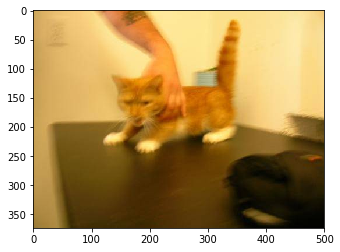

In [2]:
cat0 = cv2.imread('train/cat/cat.0.jpg')
cat0 = cv2.cvtColor(cat0, cv2.COLOR_BGR2RGB)
print(cat0.shape)

plt.imshow(cat0)

(375, 499, 3)


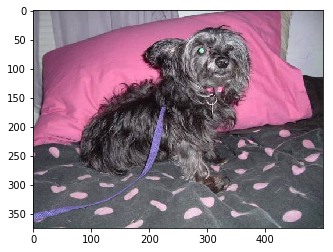

In [3]:
dog0 = cv2.imread('train/dog/dog.0.jpg')
dog0 = cv2.cvtColor(dog0, cv2.COLOR_BGR2RGB)
print(dog0.shape)

plt.imshow(dog0)

### Create ImageDataGenerator

In [4]:
image_gen = ImageDataGenerator(width_shift_range=0.1,
                               height_shift_range=0.1,
                               rescale=1/255,
                               shear_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               validation_split=0.2,
                               fill_mode='nearest')

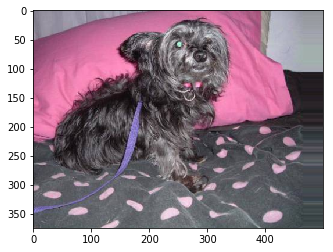

In [5]:
plt.imshow(image_gen.random_transform(dog0))

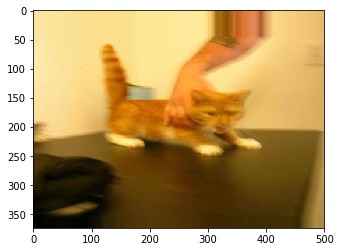

In [6]:
plt.imshow(image_gen.random_transform(cat0))

### Load data

In [7]:
directory = 'train'
batch_size = 16
image_shape = (127, 127, 3)

train_data = image_gen.flow_from_directory(directory,
                                          target_size=image_shape[:2],
                                          batch_size=batch_size,
                                          class_mode='binary',
                                          subset='training')

test_data = image_gen.flow_from_directory(directory,
                                          target_size=image_shape[:2],
                                          batch_size=batch_size,
                                          class_mode='binary',
                                          subset='validation')

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


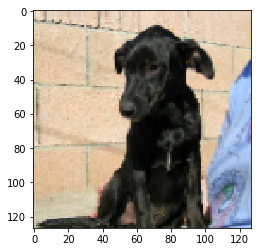

In [8]:
plt.imshow(train_data[0][0][4])

In [9]:
print(train_data.samples, test_data.samples)

20000 5000


### Create model

In [10]:
base_model = ResNet50(input_shape=image_shape,
                      include_top=False,
                      weights='imagenet')

In [11]:
base_model.trainable = False

In [12]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 127, 127, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 133, 133, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [13]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1)
])

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 4, 4, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
_________________________________________________________________


In [15]:
len(model.trainable_variables)

2

### Fit model

In [16]:
import warnings
warnings.filterwarnings('ignore')

In [17]:
earlystop = EarlyStopping(patience=10)
callbacks = [earlystop]

In [18]:
results = model.fit_generator(train_data,
                              epochs=10,
                              validation_data=test_data,
                              validation_steps=test_data.samples//batch_size,
                              steps_per_epoch=train_data.samples//batch_size,
                              callbacks=callbacks)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1250 steps, validate for 312 steps
Epoch 1/10
1250/1250 [==============================] - 123s 99ms/step - loss: 0.3751 - accuracy: 0.8130 - val_loss: 0.7914 - val_accuracy: 0.5000
Epoch 2/10
1250/1250 [==============================] - 113s 90ms/step - loss: 0.2787 - accuracy: 0.8714 - val_loss: 0.8037 - val_accuracy: 0.5000
Epoch 3/10
1250/1250 [==============================] - 95s 76ms/step - loss: 0.2587 - accuracy: 0.8821


KeyboardInterrupt: 

In [ ]:
model.save('model3.h5')

### Plot history

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].plot(results.history['accuracy'], label='Train accuracy')
ax[0].plot(results.history['val_accuracy'], label='Validation accuracy')
ax[0].legend(['Train accuracy', 'Validation accuracy'])

ax[1].plot(results.history['loss'], label='Train loss')
ax[1].plot(results.history['val_loss'], label='Validation loss')
ax[1].legend(['Train loss', 'Validation loss'])

plt.show()

### Get result

In [ ]:
test_filenames = os.listdir('test/test')
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)

test_set = test_gen.flow_from_dataframe(
    test_df,
    'test/test',
    target_size=image_shape[:2],
    batch_size=batch_size,
    x_col='filename',
    y_col=None,
    class_mode=None,
    shuffle=False
)

In [ ]:
predictions = model.predict_generator(test_set)

In [ ]:
test_df['label'] = np.round(predictions).astype(int)

In [ ]:
test_df['id'] = test_df['filename'].str.split('.').str[0]
test_df = test_df.drop('filename', axis=1)

In [ ]:
test_df.to_csv(path_or_buf='result3.csv', index=False)